<a href="https://colab.research.google.com/github/dipta007/Movie-Recommendation/blob/master/Movie_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount the Google Drive
```
ROOT = default location for colab  
PROJ = Project location (Need to create manually)  
PROJECT_PATH = Project path for later user
DATA_PATH = Data storage in gdrive
```

In [1]:
from google.colab import drive
from os.path import join
import os

ROOT = '/content/drive'     # default for the drive
PROJ = 'My Drive/Colab_data/MR1'       # path to your project on Drive
drive.mount(ROOT)           # we mount the drive at /content/drive

PROJECT_PATH = join(ROOT, PROJ)
!mkdir -p "{PROJECT_PATH}"    # in case we haven't created it already   
%cd "{PROJECT_PATH}"
%ls

DATA_PATH = './data/ml-latest-small'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab_data/MR1
data/  final-1  model  model-multi-label  multilayer_perceptron_graph.png


# Data Collection

## Get the ratings

In [2]:
import numpy as np
import pandas as pd

ratings = pd.read_csv(f"{DATA_PATH}/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## Get all the movies and their mapping
```
movies_ind_to_name = Movie index to name mapping
movies_name_to_ind = Movie name to index mapping
movies_ind_to_genre = Movie index to genres mapping
```

In [3]:
movies = pd.read_csv(f"{DATA_PATH}/movies.csv")
movies_ind_to_name = dict(zip(movies.movieId, movies.title))
movies_name_to_ind = dict(zip(movies.title, movies.movieId))
movies_ind_to_genre = dict(zip(movies.movieId, movies.genres))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Get all the Genres

#### Make all genre list same length as the maximum one

In [0]:
maxLen = max(movies['genres'].apply(lambda x: len(x.split('|'))))

def make_all_same(x):
  now = x.split("|")
  while len(now) < maxLen:
    now.append("")
  return now

movies['genres_list'] = movies['genres'].apply(make_all_same)

#### Find out the unique genres

In [5]:
s = set()
for v in movies['genres_list'].values:
  for g in v:
    s.add(g)

n_genres = len(s)
n_genres

21

#### Merge genres table to ratings table

In [6]:
ratings = pd.merge(ratings, movies, "inner", "movieId")
ratings.head()

,userId,movieId,rating,timestamp,title,genres,genres_list
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fanta..."
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fanta..."
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fanta..."
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fanta..."
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fanta..."


## Drop unnecessary columns

In [7]:
ratings = ratings.drop(['title', 'genres'], axis=1)
ratings.head()

,userId,movieId,rating,timestamp,genres_list
0,1,1,4.0,964982703,"[Adventure, Animation, Children, Comedy, Fanta..."
1,5,1,4.0,847434962,"[Adventure, Animation, Children, Comedy, Fanta..."
2,7,1,4.5,1106635946,"[Adventure, Animation, Children, Comedy, Fanta..."
3,15,1,2.5,1510577970,"[Adventure, Animation, Children, Comedy, Fanta..."
4,17,1,4.5,1305696483,"[Adventure, Animation, Children, Comedy, Fanta..."


# Data Processing

## Import necessary libraries

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

## Encode User ID(s)


In [0]:
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['userId'].values)
n_users = ratings['user'].nunique() + 10

## Encode Movie ID(s)

In [0]:
movie_enc = LabelEncoder()
movie_enc.fit(movies['movieId'])
ratings['movie'] = movie_enc.transform(ratings['movieId'].values)
n_movies = movies['movieId'].nunique()

## Encode Genere List

In [11]:
genre_enc = LabelEncoder()
genre_enc.fit(list(s))
ratings['genres_list'] = ratings['genres_list'].apply(lambda x: genre_enc.transform(x))
ratings.head()

,userId,movieId,rating,timestamp,genres_list,user,movie
0,1,1,4.0,964982703,"[3, 4, 5, 6, 10, 0, 0, 0, 0, 0]",0,0
1,5,1,4.0,847434962,"[3, 4, 5, 6, 10, 0, 0, 0, 0, 0]",4,0
2,7,1,4.5,1106635946,"[3, 4, 5, 6, 10, 0, 0, 0, 0, 0]",6,0
3,15,1,2.5,1510577970,"[3, 4, 5, 6, 10, 0, 0, 0, 0, 0]",14,0
4,17,1,4.5,1305696483,"[3, 4, 5, 6, 10, 0, 0, 0, 0, 0]",16,0


## Get Ratings Info

In [12]:
ratings['rating'] = ratings['rating'].values.astype(np.float32)
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])

n_users, n_movies, n_genres, min_rating, max_rating

(620, 9742, 21, 0.5, 5.0)

## Make the data processed for training and test

In [13]:
X1 = ratings[['user', 'movie']].values
X2 = np.array([list(val) for val in ratings['genres_list'].values])
X = np.concatenate((X1, X2), axis=1)
y = ratings['rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, 
                                                    random_state=47)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((90752, 12), (10084, 12), (90752,), (10084,))

## Make data ready for feeeding into model

In [0]:
X_train_array = [X_train[:, 0], X_train[:, 1], X_train[:, 2:]]
X_test_array = [X_test[:, 0], X_test[:, 1], X_test[:, 2:]]

## Delete the unused data to free Ram

In [15]:
del X1, X2, X, y
del X_train, X_test
del ratings, movies
import gc
gc.collect()

0

# Model Training

In [16]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l2
from keras.layers import Concatenate, Dense, Dropout, Lambda, Flatten

def Model1(min_rating, max_rating):
    user = Input(shape=(1,))
    u = Embedding(n_users, 50)(user)
    u = Flatten()(u)
    
    movie = Input(shape=(1,))
    m = Embedding(n_movies, 50, name="movies")(movie)
    m = Flatten()(m)

    genre = Input(shape=(10,))
    g = Embedding(n_genres, 10)(genre)
    g = Flatten()(g)
    
    x = Concatenate()([u, m, g])
    x = Dropout(0.05)(x)
    
    x = Dense(128, kernel_initializer='he_normal', activation="relu")(x)

    x = Dense(10, kernel_initializer='he_normal', activation="relu")(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1, kernel_initializer='he_normal', activation="sigmoid")(x)

    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    
    model = Model(inputs=[user, movie, genre], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
    return model

Using TensorFlow backend.


## Model Summary and Visualize

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        31000       input_1[0][0]                    
____________________________________________________________________________________________

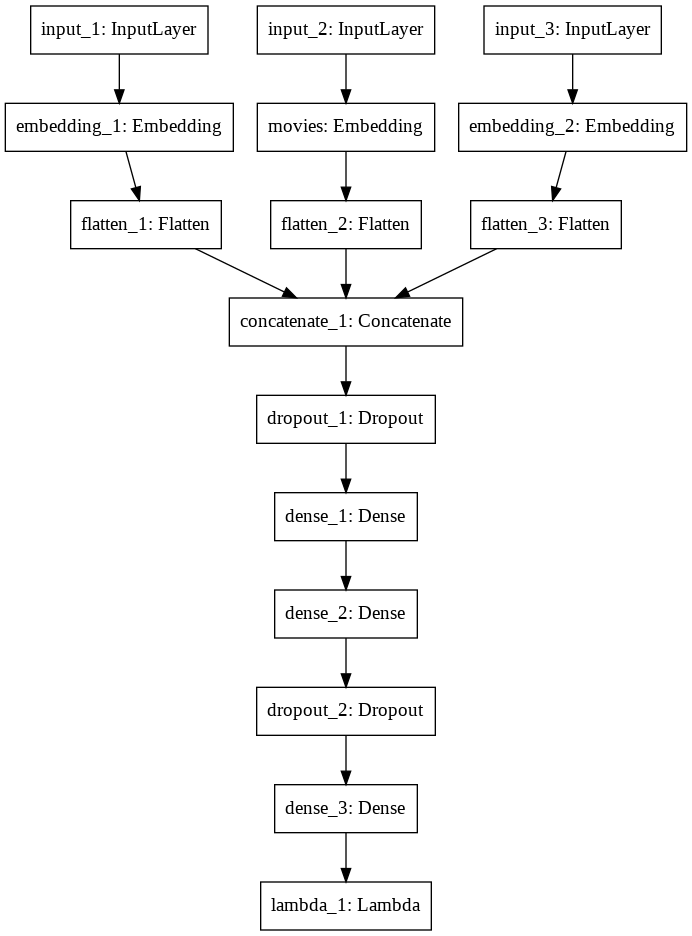

In [17]:
model = Model1(min_rating, max_rating)
model.summary()

from keras.utils import plot_model
plot_model(model, to_file='multilayer_perceptron_graph.png')

## Callbacks for MODEL

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

CHECKPOINT_PATH = './final-1'

callbacks = []
callbacks.append(EarlyStopping(monitor='val_loss', patience=4))
callbacks.append(ModelCheckpoint(CHECKPOINT_PATH,  monitor='val_loss', save_best_only=True, save_weights_only=True))

## Start Training

In [19]:
history = model.fit(x=X_train_array, y=y_train, batch_size=128, epochs=50,
                    verbose=1, validation_data=(X_test_array, y_test),
                    callbacks=callbacks)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 90752 samples, validate on 10084 samples
Epoch 1/50
90752/90752 [==============================] - 6s 66us/step - loss: 0.9309 - accuracy: 0.2785 - val_loss: 0.7646 - val_accuracy: 0.3110
Epoch 2/50
90752/90752 [==============================] - 5s 58us/step - loss: 0.7780 - accuracy: 0.3102 - val_loss: 0.7449 - val_accuracy: 0.3210
Epoch 3/50
90752/90752 [==============================] - 5s 56us/step - loss: 0.7217 - accuracy: 0.3261 - val_loss: 0.7345 - val_accuracy: 0.3272
Epoch 4/50
90752/90752 [==============================] - 5s 57us/step - loss: 0.6900 - accuracy: 0.3342 - val_loss: 0.7319 - val_accuracy: 0.3258
Epoch 5/50
90752/90752 [==============================] - 5s 56us/step - loss: 0.6580 - accuracy: 0.3439 - val_loss: 0.7394 - val_accuracy: 0.3304
Epoch 6/50
90752/90752 [==============================] - 5s 56us/step - loss: 0.6265 - accuracy: 0.3523 - val_loss: 0.7381 - val_accuracy: 0.3289
Epoch 7/50
90752/90752 [==============================] - 5s 58us/st

## Load the BEST model

In [0]:
model.load_weights(CHECKPOINT_PATH)

## Evaluate on the Test data

In [21]:
model.evaluate(X_test_array, y_test)

10084/10084 [==============================] - 0s 23us/step


[0.7318713412025721, 0.3257635831832886]

# Model Prediction

## Make the real data ready for model

In [0]:
def get_genre(movie_id):
  genres = movies_ind_to_genre[movie_id]
  genres = make_all_same(genres)
  return genre_enc.transform(genres).tolist()

def get_same_data_as_model(movies, ratings):
  X1 = []
  X2 = []
  X3 = []
  Y = []
  TX1 = []
  TX2 = []
  TX3 = []
  for (ind, movie) in enumerate(movies):
    user = n_users - 4
    enc_movie_id = movie_enc.transform([movie])[0]
    genres = get_genre(movie)
    X1.append(user)
    X2.append(enc_movie_id)
    X3.append(genres)
    Y.append(ratings[ind])
  
  for movieId in range(n_movies):
    user = n_users - 4
    org_movie_id = movie_enc.inverse_transform([movieId])[0]
    genres = get_genre(org_movie_id)
    TX1.append(user)
    TX2.append(movieId)
    TX3.append(genres)

  return [X1, X2, X3], Y, [TX1, TX2, TX3]

## Function to get prediction

In [0]:
def get_prediction(Movies, Ratings, top = 10):
  NX, NY, TX = get_same_data_as_model(Movies, Ratings)
  NX_a = [NX[0], NX[1], NX[2]]
  model.fit(NX_a, NY, batch_size=128, epochs=10, verbose=0)
  res = model.predict([TX[0], TX[1], TX[2]])
  model.load_weights(CHECKPOINT_PATH)

  res_movies = [(rating[0], movieId) for (movieId, rating) in enumerate(res)]
  res_movies = [(rating, movie_enc.inverse_transform([movieId])[0]) for (movieId, rating) in enumerate(res)]
  res_movies.sort(key=lambda x: x[0], reverse=True)
  return res_movies[:top]

In [32]:
# eat pray love, Eternal Sunshine of the Spotless Mind, the intern, The notebook
Movies = [80551, 7361, 140110, 8533, 858, 111]
Ratings = [5, 5, 5, 5, 1, 1]
# godfather, taxidriver, raging bull, goodfellas
Movies = [858, 111, 1228, 1213, 80551, 7361]
Ratings = [5, 5, 5, 5, 1, 1]

res = get_prediction(Movies, Ratings, 20)
for (rating, movie_id) in res:
  print(f"{movies_ind_to_name[movie_id][0:60].ljust(70)} Genre: {movies_ind_to_genre[movie_id]}")

Long Goodbye, The (1973)                                               Genre: Crime|Film-Noir
Three Billboards Outside Ebbing, Missouri (2017)                       Genre: Crime|Drama
Control Room (2004)                                                    Genre: Documentary|War
Shawshank Redemption, The (1994)                                       Genre: Crime|Drama
Goodfellas (1990)                                                      Genre: Crime|Drama
Imposter, The (2012)                                                   Genre: Documentary
Godfather, The (1972)                                                  Genre: Crime|Drama
Trial, The (Procès, Le) (1962)                                         Genre: Drama
Rififi (Du rififi chez les hommes) (1955)                              Genre: Crime|Film-Noir|Thriller
Manufacturing Consent: Noam Chomsky and the Media (1992)               Genre: Documentary|War
Usual Suspects, The (1995)                                             Genre: Cri